# Flight Analytics

## Executive Summary

Being stuck at the airport due to a delayed flight is not fun, but what if you could know in advance which flights would be delayed? A very obvious reason for delay is weather, but this project attemps to explore other non-weather related issue that may lead to delays. Interesting, certain times of the day and months of the flight appear to have more delayed flights. Some airports also appear to have more delayed flights. These conclusions seem to support that operational issues are contributing factors to delays. Nevertheless, scheduling data do not seem to be sufficient in predicting delays. Future studies should focus on the exact effect of weather on flight delays. 

## Data Description



3 sets of csv were obtained from Kaggle:

2015 Flight Delays and Cancellations dataset, collected and published by the DOT's Bureau of Transportation Statistics. This contains airport, airline, and flight-level information on US domestic flights, including on-time statistics and any delays. (https://www.kaggle.com/usdot/flight-delays)



## Some Guiding Questions


1. Which airports and airlines tend to have most delayed or cancelled flights?
2. Do flight times or timing of the year affect delays?
3. Can we predict flight delays based on historical schedule data alone?

## Main Learning Objectives



1. Data visualization using plotly and ggplot
2. Using SHAP to explain tree-based models 
3. Using randomized grid search CV to find best parameters

## I. Data Cleaning and Preparation

Description of what needs to be done

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import chart_studio.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotnine import *
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split 
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score


import shap

In [2]:
def get_data(save = False, nrows = None):
    ## Read in data
    flights = pd.read_csv('flights.csv',nrows = nrows, dtype={'SCHEDULED_DEPARTURE': str,
                                               'DEPARTURE_TIME': str,
                                               'SCHEDULED_ARRIVAL': str,
                                               'ARRIVAL_TIME': str})
    
    ## Drop columns not relevant to the current analysis
    columns_to_drop = ['YEAR', 'DAY','TAXI_OUT','WHEELS_OFF', 'SCHEDULED_TIME',
                       'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 
                       'TAXI_IN','CANCELLATION_REASON','AIR_SYSTEM_DELAY', 
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY',
                       'DIVERTED','CANCELLED','TAIL_NUMBER','DESTINATION_AIRPORT','DEPARTURE_TIME',
                        'SCHEDULED_ARRIVAL','ARRIVAL_TIME']
    
    flights = flights[[col for col in flights.columns if col not in columns_to_drop]]
    
    ## Convert columns to appropriate data types
    flights[['AIRLINE','FLIGHT_NUMBER','ORIGIN_AIRPORT']] = flights[['AIRLINE','FLIGHT_NUMBER','ORIGIN_AIRPORT']].astype(str)
    
    flights['SCHEDULED_DEPARTURE']=flights['SCHEDULED_DEPARTURE'].apply(clean_time)
    
    ## Some airports are given in numbers(?), these are removed as they are either cancelled or diverted flights
    flights = flights.loc[flights['ORIGIN_AIRPORT'].str.match("^[a-zA-Z]+$")]
    
    ## Create "Delay" column based on arrival delay minutes - here it's set to any arrivals above 15 mins (FAA designation)
    flights['Delay'] = np.where(flights['ARRIVAL_DELAY']>15,1,0)
    
    ## Read in and create a dictionary of airlines 
    airlines = pd.read_csv('airlines.csv')
        
    ## Drop missing Values
    flights = flights.dropna()
    
    return flights, airlines

## Function to convert time into proper format
def clean_time(time):
    if pd.isnull(time):
        return np.nan
    elif int(time[:2])==24:
        new_time = dt.time(0,int(time[2:4]))
        return new_time
    else:
        new_time = dt.time(int(time[:2]),int(time[2:4]))
        return new_time


flights, airlines = get_data()

Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
## Summary statistics: counts of delays and delays above an hour
summary = pd.DataFrame({
    'Total Flights': [flights.shape[0],100],
    'Total Delayed': [sum(flights['Delay']),round(100*(sum(flights['Delay'])/flights.shape[0]),2)],
    'Delayed >1h': [flights.loc[flights['ARRIVAL_DELAY']>60].shape[0],round(100*(flights.loc[flights['ARRIVAL_DELAY']>60].shape[0]/flights.shape[0]),2)],
}, index=['Count', 'Percent'])
summary

,Total Flights,Total Delayed,Delayed >1h
Count,5231130,966261.00,303209.0
Percent,100,18.47,5.8


### Conclusion

Even though the total amount of delayed flights appear high (over 18% of the time!), significant delays (here defined as above 1 hour delay) constitute only 5.8% of the flights. This is not bad!

In the next few sections, we could look into whether there are some patterns of delay associated with airports or airlines

## II. Airport-Level Analysis

In [5]:
## Import and Clean airport data
airports = pd.read_csv('airports.csv')
airports = airports[['IATA_CODE','AIRPORT','LATITUDE','LONGITUDE']]

## Create Flight Frequency Table by Departure Airport
table = flights.groupby('ORIGIN_AIRPORT', as_index = False).aggregate({'FLIGHT_NUMBER':'count'})
table = table.merge(airports, how = 'left', left_on = 'ORIGIN_AIRPORT', right_on = 'IATA_CODE')
table['text'] = table['AIRPORT'] + '<br>Annual Number of Flights ' + (table['FLIGHT_NUMBER']).astype(str)

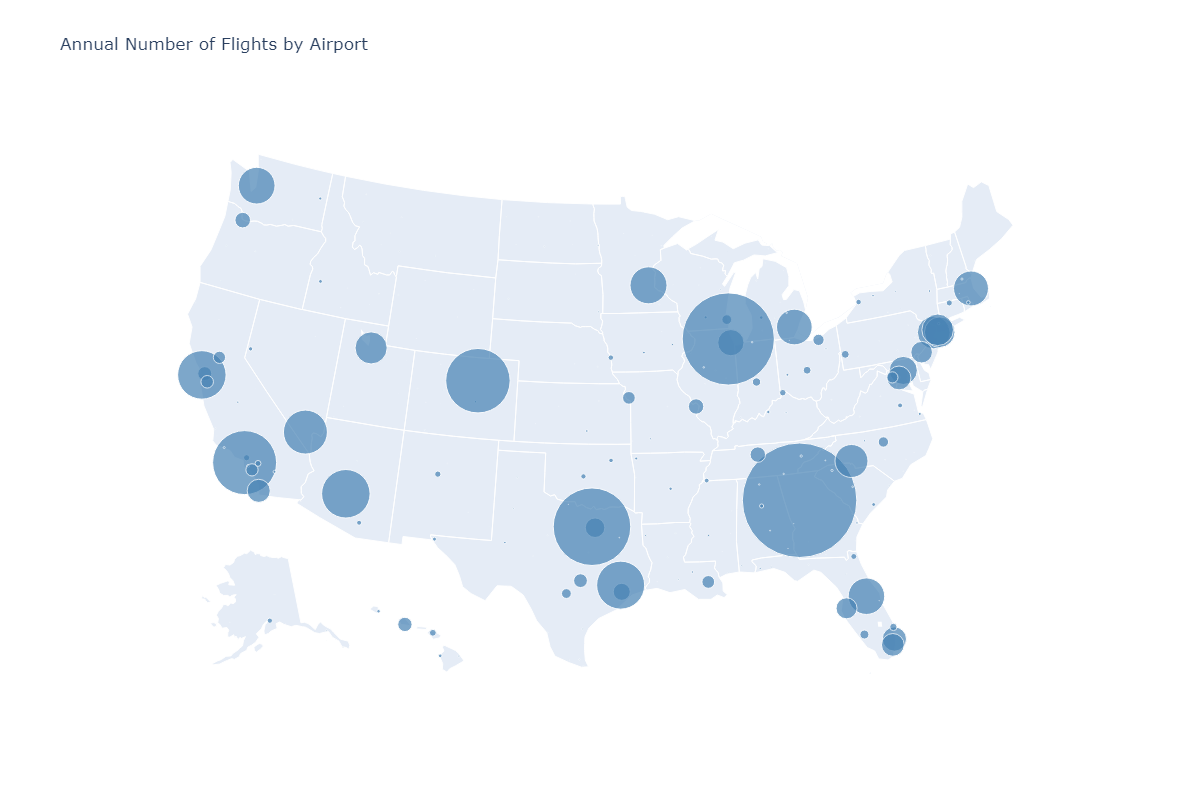

In [6]:
## Map of USA showing airports with highest number of flights
scale = 3000
fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = table['LONGITUDE'],
        lat = table['LATITUDE'],
        text = table['text'],
        marker = go.scattergeo.Marker(
            size = table['FLIGHT_NUMBER']/scale
        ), marker_color = 'steelblue'))

fig.update_layout(
        title = 'Annual Number of Flights by Airport',
        geo_scope='usa',
    )

fig.show("png",height = 800, width = 1200)

In [7]:
## Airports and count of delays and cancellations
airport_summary = flights.groupby('ORIGIN_AIRPORT', as_index = False).agg({
    'FLIGHT_NUMBER':'count',
    'Delay': 'sum',
    'ARRIVAL_DELAY': ['min','mean','median','max']
    
})

airport_summary.columns = ["_".join(x) for x in airport_summary.columns.ravel()]

airport_summary['% Delay'] = round(100*(airport_summary['Delay_sum']/airport_summary['FLIGHT_NUMBER_count']),2)

airport_summary = airport_summary.rename(columns={'ORIGIN_AIRPORT_':'Airport',
                                                 'FLIGHT_NUMBER_count': 'Number of Flights',
                                                 'Delay_sum': 'Total Delays',
                                                 'ARRIVAL_DELAY_min': 'Min Delay',
                                                 'ARRIVAL_DELAY_mean': 'Avg Delay',
                                                 'ARRIVAL_DELAY_median': 'Median Delay',
                                                 'ARRIVAL_DELAY_max': 'Max Delay'
    
})
airport_summary.sort_values('% Delay', ascending = False).head(10)

,Airport,Number of Flights,Total Delays,Min Delay,Avg Delay,Median Delay,Max Delay,% Delay
133,GST,76,33,-19.0,21.763158,10.5,179.0,43.42
9,ADK,88,35,-80.0,11.034091,10.0,92.0,39.77
154,ILG,95,37,-44.0,24.063158,4.0,279.0,38.95
234,PBG,278,88,-60.0,9.496403,-3.0,226.0,31.65
293,STC,77,24,-27.0,19.558442,0.0,315.0,31.17
246,PPG,106,31,-28.0,21.500000,5.5,809.0,29.25
19,ASE,3263,943,-48.0,15.492492,-2.0,1076.0,28.90
209,MMH,140,40,-37.0,7.928571,-6.0,198.0,28.57
231,OTH,264,70,-43.0,14.333333,-3.0,305.0,26.52
313,UST,144,38,-36.0,8.972222,-5.5,236.0,26.39


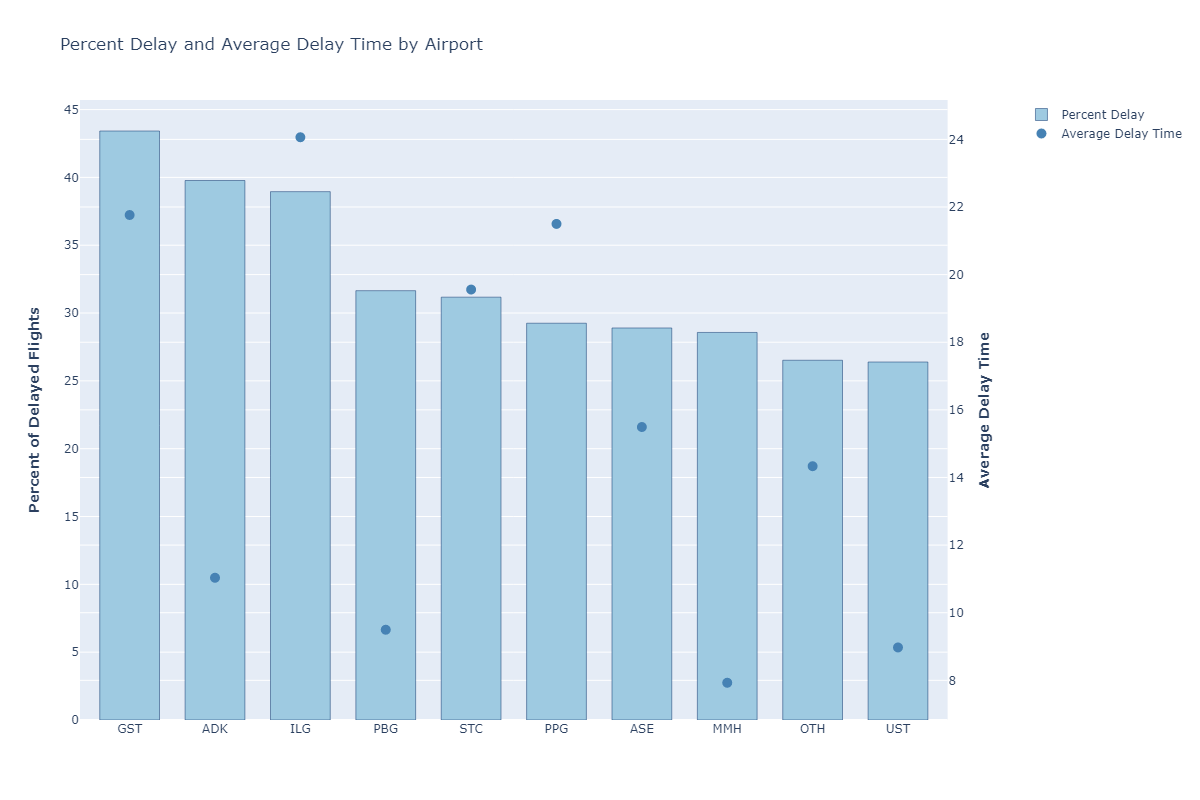

In [8]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

tope_10 = airport_summary.sort_values('% Delay', ascending = False).head(10)

fig.add_trace(
    go.Bar(x = tope_10['Airport'], y = tope_10['% Delay'], name = 'Percent Delay',
          marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
          width = 0.7),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x = tope_10['Airport'], y = tope_10['Avg Delay'], name = 'Average Delay Time', 
               mode='markers', marker_size= 10, marker_color = 'steelblue'),
    secondary_y=True
)

fig.update_layout(
    title_text="Percent Delay and Average Delay Time by Airport"
)

fig.update_yaxes(title_text="<b>Percent of Delayed Flights</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Average Delay Time</b>", secondary_y=True)

fig.show("png",height = 800, width = 1200)


### Conclusion:



The top 10 airports with the highest percentage of delays have delays 25 - 50% of the time, though the median of these delays are not very high - worst is 10.5 minutes. Nevertheless, the mean is much higher, suggesting that it is a positively skewed distritbution.

We can also see that the maximum delays are very long - some lasting for more than 1000 hours! Although, there doesn't seem to be a trend between percent dalys and average delay time. It would be important for airlines and airports to pick the right metric to investigate in reducing overall delays. 


## III. Airline-Level Analysis

In [9]:
## Merge Airlines Names onto flights
flights = flights.merge(airlines, how = 'left', left_on = 'AIRLINE', right_on = 'IATA_CODE')
flights.drop(['IATA_CODE'], axis = 1, inplace = True)
flights = flights.rename(columns={'AIRLINE_x':'Airline Code',
                                  'AIRLINE_y':'Airline Name'
    
})

In [10]:
## Summary of busiest airlines

airlines_summary = flights.groupby('Airline Name', as_index = False).agg({
    'FLIGHT_NUMBER':'count',
    'Delay': 'sum',
    'ARRIVAL_DELAY': ['min','mean','median','max']
    
})

airlines_summary.columns = ["_".join(x) for x in airlines_summary.columns.ravel()]

airlines_summary['% Delay'] = round(100*(airlines_summary['Delay_sum']/airlines_summary['FLIGHT_NUMBER_count']),2)

airlines_summary = airlines_summary.rename(columns={'Airline Name_':'Airline',
                                                 'FLIGHT_NUMBER_count': 'Number of Flights',
                                                 'Delay_sum': 'Total Delays',
                                                 'ARRIVAL_DELAY_min': 'Min Delay',
                                                 'ARRIVAL_DELAY_mean': 'Avg Delay',
                                                 'ARRIVAL_DELAY_median': 'Median Delay',
                                                 'ARRIVAL_DELAY_max': 'Max Delay'
    
})


airlines_summary.sort_values('% Delay', ascending = False)

,Airline,Number of Flights,Total Delays,Min Delay,Avg Delay,Median Delay,Max Delay,% Delay
10,Spirit Air Lines,105059,31100,-60.0,15.210786,1.0,833.0,29.60
5,Frontier Airlines Inc.,82005,21711,-73.0,13.729468,-1.0,1101.0,26.48
7,JetBlue Airways,240304,53405,-76.0,6.949339,-5.0,1002.0,22.22
2,American Eagle Airlines Inc.,257130,56431,-63.0,7.316540,-5.0,1272.0,21.95
12,United Air Lines Inc.,462086,96065,-81.0,6.211316,-5.0,1294.0,20.79
3,Atlantic Southeast Airlines,509621,98932,-64.0,6.964550,-4.0,1223.0,19.41
9,Southwest Airlines Co.,1138350,215470,-73.0,4.837831,-4.0,659.0,18.93
13,Virgin America,55813,10497,-78.0,4.979539,-3.0,651.0,18.81
8,Skywest Airlines Inc.,528328,97514,-69.0,6.221438,-4.0,1372.0,18.46
1,American Airlines Inc.,636554,115542,-87.0,3.935214,-6.0,1971.0,18.15


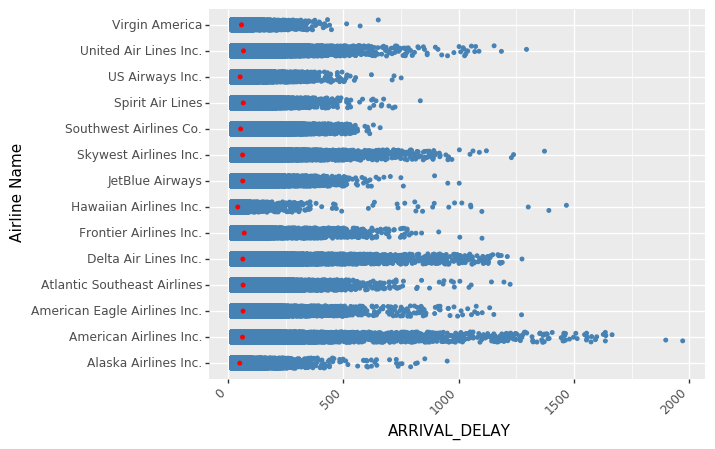

<ggplot: (192495708231)>

In [11]:
## Airline and average of delay time

ggplot(flights.loc[flights['Delay']==1],aes(x='Airline Name',y='ARRIVAL_DELAY')) +\
    geom_jitter(position=position_jitter(0.2),color = 'steelblue',size = 1) +\
    stat_summary(fun_y= np.mean, geom="point", size=1, color="red") +\
    theme(axis_text_x = element_text(angle=45, hjust=1)) +\
    coord_flip()


In [12]:
## Summary of airline arrival and departure delays

airlines_delay_summ = flights.groupby('Airline Name', as_index = False).agg({
    'DEPARTURE_DELAY':'mean',
    'ARRIVAL_DELAY': 'mean'    
})

airlines_delay_summ = airlines_delay_summ.rename(columns={'Airline Name':'Airline',
                                                 'DEPARTURE_DELAY': 'Avg Departure Delay',
                                                 'ARRIVAL_DELAY': 'Avg Arrival Delay'
    
})


airlines_delay_summ

,Airline,Avg Departure Delay,Avg Arrival Delay
0,Alaska Airlines Inc.,1.892036,-0.791409
1,American Airlines Inc.,9.254027,3.935214
2,American Eagle Airlines Inc.,10.523229,7.316540
3,Atlantic Southeast Airlines,8.971355,6.964550
4,Delta Air Lines Inc.,7.706897,0.680265
5,Frontier Airlines Inc.,14.217548,13.729468
6,Hawaiian Airlines Inc.,0.496856,2.161856
7,JetBlue Airways,11.753367,6.949339
8,Skywest Airlines Inc.,8.112207,6.221438
9,Southwest Airlines Co.,10.928065,4.837831


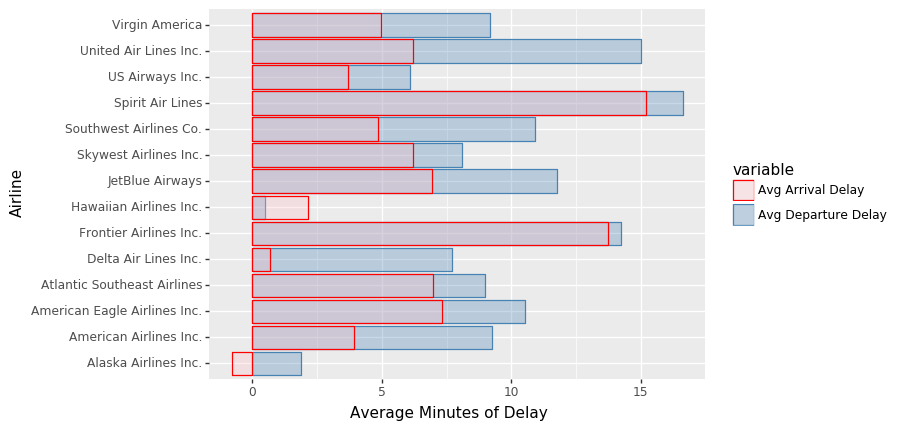

<ggplot: (192495291456)>

In [13]:
temp = pd.melt(airlines_delay_summ, id_vars=['Airline'], value_vars=['Avg Departure Delay','Avg Arrival Delay'])

ggplot(temp, aes(x='Airline', y='value', fill='variable', color='variable')) +\
  geom_bar(stat="identity",position ="identity",alpha=0.3) +\
  scale_colour_manual(values=['red','steelblue']) +\
  scale_fill_manual(values=['pink','steelblue']) +\
  labs(y = "Average Minutes of Delay") +\
  coord_flip()

### Conclusion:

As already seen in the last section, most delay times are below 200 minutes, but there are outliers with extreme delay times that skews the average of delay times.

Every airline has an average arrival delay that is much higher than the average departure delay, thus confirming that airlines almost always gives itself buffer time to avoid any arrival delays. Some airlines appear to have more buffer than others, for exampl, Delta Airlines. Interestingly, Delta Airlines also has the lowest rate of delay. This seems to suggest that their buffering strategy is working.

## IV. Time of Flight Analysis

The code in this secion are all very similar - the analysis is essentially down on different time scales to study the patterns of delays within a day, a week, or a year. I tried to use different charts to illustrate the different trends. This also turned out to be a good way to start using more subplots in the Plotly package.

In [14]:
## Monthly delay counts and minutes
monthly_summary = flights.groupby('MONTH', as_index = False).agg({'FLIGHT_NUMBER': 'count',
                                                                  'Delay': 'sum',
                                                                  'ARRIVAL_DELAY': ['min','mean','median','max']})




monthly_summary.columns = ["_".join(x) for x in monthly_summary.columns.ravel()]

monthly_summary['% Delay'] = round(100*(monthly_summary['Delay_sum']/monthly_summary['FLIGHT_NUMBER_count']),2)

monthly_summary = monthly_summary.rename(columns={'MONTH_':'Month',
                                                 'FLIGHT_NUMBER_count': 'Total Flights',
                                                 'Delay_sum': 'Total Delays',
                                                 'ARRIVAL_DELAY_min': 'Min Delay',
                                                 'ARRIVAL_DELAY_mean': 'Avg Delay',
                                                 'ARRIVAL_DELAY_median': 'Median Delay',
                                                 'ARRIVAL_DELAY_max': 'Max Delay'
    
})
monthly_summary.sort_values('% Delay', ascending = False).head(10)

,Month,Total Flights,Total Delays,Min Delay,Avg Delay,Median Delay,Max Delay,% Delay
5,6,492847,112041,-66.0,9.601590,-3.0,1508.0,22.73
1,2,407663,91790,-79.0,8.320500,-2.0,1627.0,22.52
0,1,457013,92407,-82.0,5.813583,-4.0,1971.0,20.22
6,7,514384,103967,-73.0,6.431775,-4.0,1636.0,20.21
10,12,469717,93313,-80.0,6.092903,-5.0,1636.0,19.87
2,3,492138,91751,-87.0,4.920673,-4.0,1598.0,18.64
7,8,503956,90754,-80.0,4.607372,-5.0,1898.0,18.01
4,5,489641,86353,-76.0,4.485019,-5.0,1480.0,17.64
3,4,479251,78773,-87.0,3.163190,-5.0,1554.0,16.44
9,11,462367,67576,-80.0,1.100784,-6.0,1638.0,14.62


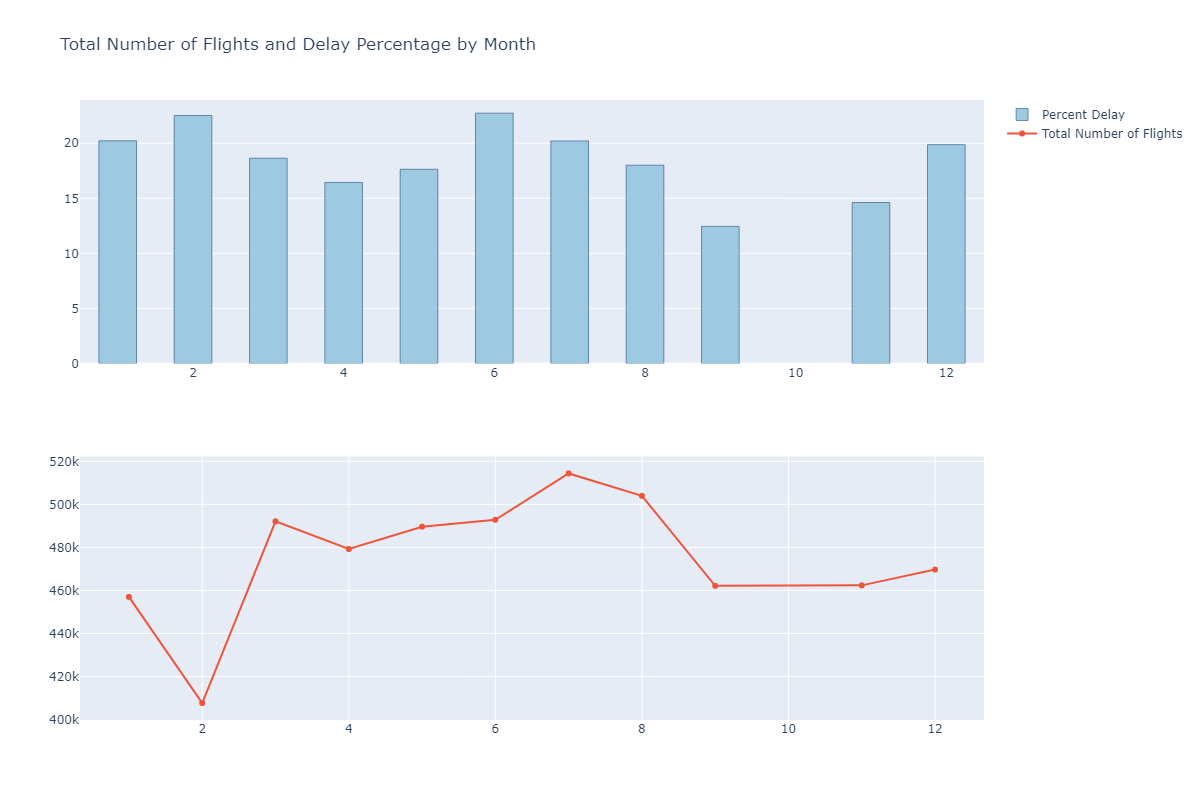

In [15]:
fig = make_subplots(
    rows = 2, cols = 1,
    column_widths=[0.6],
    row_heights=[0.4, 0.4])

fig.add_trace(
    go.Bar(x = monthly_summary['Month'], y = monthly_summary['% Delay'], 
              name = 'Percent Delay', width = 0.5,
              marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)'),
              row = 1, col = 1
)

fig.add_trace(
    go.Scatter(x = monthly_summary['Month'], y = monthly_summary['Total Flights'], 
               name = 'Total Number of Flights'),
               row = 2, col = 1
               
)

fig.update_layout(
    title_text="Total Number of Flights and Delay Percentage by Month"
)

fig.show("png",height = 800, width = 1200)


In [16]:
## DoW delay counts and minutes
DOW_summary = flights.groupby('DAY_OF_WEEK', as_index = False).agg({'FLIGHT_NUMBER': 'count',
                                                                    'Delay': 'sum',
                                                                    'ARRIVAL_DELAY': ['min','mean','median','max']})




DOW_summary.columns = ["_".join(x) for x in DOW_summary.columns.ravel()]

DOW_summary['% Delay'] = round(100*(DOW_summary['Delay_sum']/DOW_summary['FLIGHT_NUMBER_count']),2)

DOW_summary = DOW_summary.rename(columns={'DAY_OF_WEEK_':'Day of Week',
                                          'FLIGHT_NUMBER_count': 'Total Flights',
                                           'Delay_sum': 'Total Delays',
                                           'ARRIVAL_DELAY_min': 'Min Delay',
                                           'ARRIVAL_DELAY_mean': 'Avg Delay',
                                           'ARRIVAL_DELAY_median': 'Median Delay',
                                           'ARRIVAL_DELAY_max': 'Max Delay'
    
})

DOW_summary['Day of Week'].replace({1: 'Monday',
                                    2: 'Tuesday',
                                    3: 'Wednesday',
                                    4: 'Thursday',
                                    5: 'Friday',
                                    6: 'Saturday',
                                    7: 'Sunday'}, inplace=True)
## Sort table by DoW
Days_order = pd.Categorical(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
              ordered=True)

DOW_summary.sort_index(level=Days_order)

DOW_summary

,Day of Week,Total Flights,Total Delays,Min Delay,Avg Delay,Median Delay,Max Delay,% Delay
0,Monday,775714,154052,-81.0,6.740670,-4.0,1636.0,19.86
1,Tuesday,763813,140999,-80.0,5.035154,-5.0,1598.0,18.46
2,Wednesday,778658,141165,-82.0,4.370272,-5.0,1576.0,18.13
3,Thursday,775433,154679,-87.0,6.257192,-4.0,1636.0,19.95
4,Friday,770324,142903,-79.0,4.706447,-4.0,1971.0,18.55
5,Saturday,627502,98837,-87.0,2.184446,-6.0,1898.0,15.75
6,Sunday,739686,133626,-80.0,4.370548,-5.0,1665.0,18.07


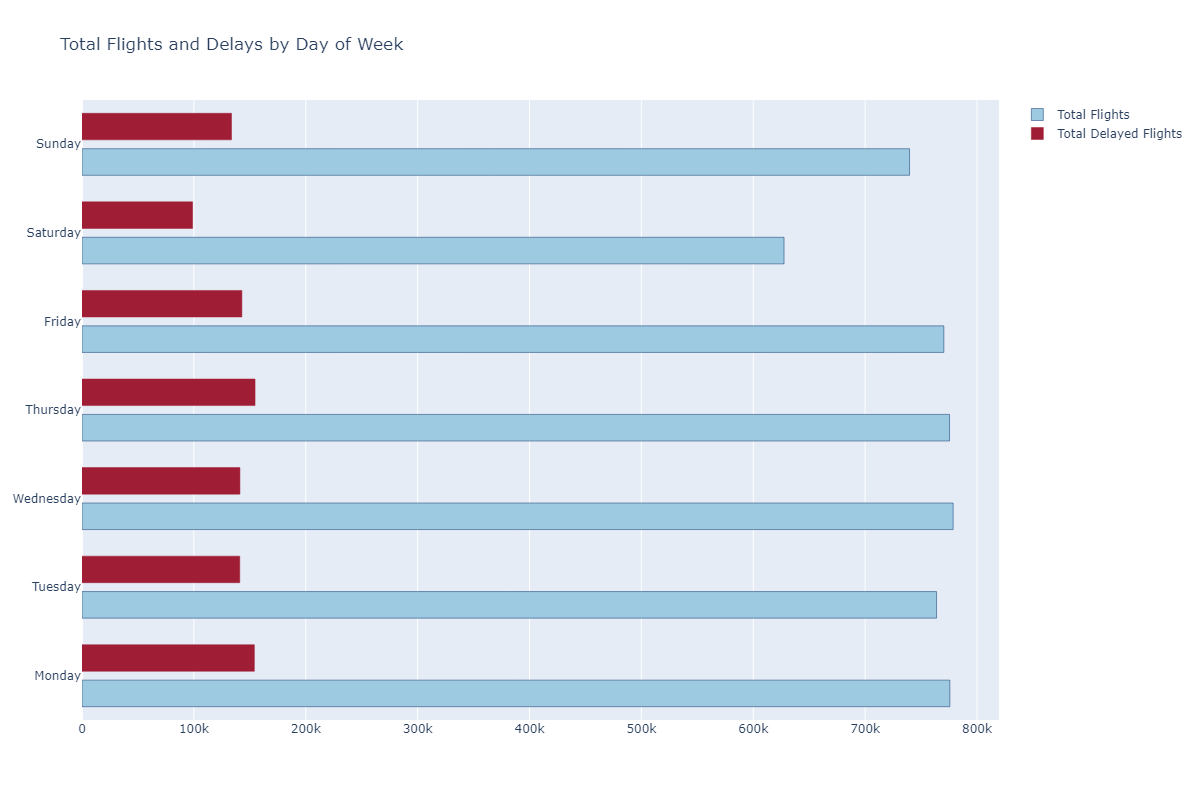

In [17]:
fig = go.Figure()


fig.add_trace(
    go.Bar(y = DOW_summary['Day of Week'], x = DOW_summary['Total Flights'], 
              name = 'Total Flights', width = 0.3,
              marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
           orientation = 'h'
              )
)

fig.add_trace(
    go.Bar(y = DOW_summary['Day of Week'], x = DOW_summary['Total Delays'], 
               name = 'Total Delayed Flights',width = 0.3,
              marker_color='rgb(159, 29, 53)', marker_line_color='rgb(159, 29, 53)',
          orientation = 'h'
          )
               
)

fig.update_layout(
    title_text="Total Flights and Delays by Day of Week"
)

fig.show("png",height = 800, width = 1200)

In [18]:
## Get Scheduled Departure Time splots

flights['Time'] = (flights['SCHEDULED_DEPARTURE'].apply(lambda x: x.hour))


flights['Time_Period'] = flights['Time']//6
flights['Time_Period'].replace({0: 'Night',
                                1: 'Morning',
                                2: 'Afternoon',
                                3: 'Evening'}, inplace = True)


In [19]:
## TimeofDay delay counts and minutes
ToD_summary = flights.groupby('Time', as_index = False).agg({'FLIGHT_NUMBER': 'count',
                                                             'Delay': 'sum',
                                                             'ARRIVAL_DELAY': 'mean'})


ToD_summary['% Delay'] = round(100*(ToD_summary['Delay']/ToD_summary['FLIGHT_NUMBER']),2)

ToD_summary = ToD_summary.rename(columns={'FLIGHT_NUMBER': 'Number of Flights',
                                          'Delay': 'Total Delays',
                                          'ARRIVAL_DELAY': 'Avg Delay'
    
})
ToD_summary = ToD_summary.sort_values('Time', ascending = True)

## TimeofDay delay by period

Time_Period_summary = flights.groupby('Time_Period', as_index = False).agg({'FLIGHT_NUMBER': 'count'})

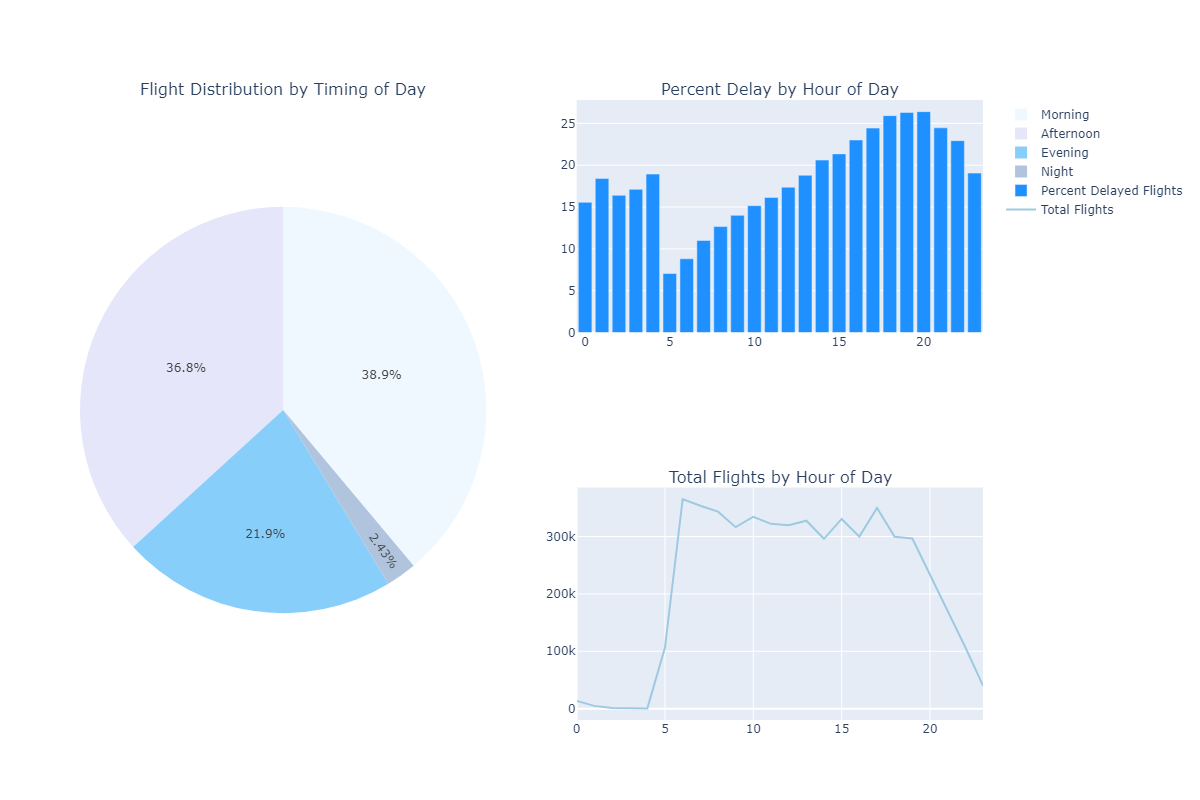

In [20]:
fig = make_subplots(
    rows = 2, cols = 2,
    column_widths = [0.6, 0.6],
    row_heights=[0.4,0.4],
    specs=[[{"type": "domain", "rowspan": 2},{"type":"scatter"}],
            [None , {"type":"bar"}]],
    subplot_titles = ['Flight Distribution by Timing of Day',
                      'Percent Delay by Hour of Day',
                      'Total Flights by Hour of Day']
)

fig.add_trace(
    go.Pie(labels = Time_Period_summary['Time_Period'], values = Time_Period_summary['FLIGHT_NUMBER'],
          marker=dict(colors= ['rgb(230,230,250)', 'rgb(135,206,250)','rgb(240,248,255)','rgb(176,196,222)'])),
    row = 1, col = 1
)

fig.add_trace(
    go.Bar(x = ToD_summary['Time'], y = ToD_summary['% Delay'],
          marker_color='rgb(30,144,255)', name = 'Percent Delayed Flights'),
    row = 1, col = 2
)

fig.add_trace(
    go.Scatter(x = ToD_summary['Time'], y = ToD_summary['Number of Flights'],
              marker_color='rgb(158,202,225)', name = 'Total Flights'),
    row = 2, col = 2
)

fig.show("png",height = 800, width = 1200)

### Conclusion:

The volume of flights are much lower in the winter months (Nov - Feb) compared to the rest of the months of the year. Interestingly, the percentage of delays do not follow the same pattern. For example, Februrary sees the least volume of flights, but the second highest percentage of delay. This suggests that the total volume of flights is not associated with the percentage of flights that are delayed, but is somehow dependent on the month of the flight. This intuitively makes sense as weather is likely the biggest contributer to delays, and weather varies dramatically by month.

The aggregated trend by day of the week, on the other hand, does not show an obvious pattern. It appears that the number of delayed flights simply vary with the total volume of flights. Overall, this suggests that the day of the week does not have an influence on delayed flights.

On a daily basis,  most of the flights occur in the morning and afternoon. Interestingly, there are more delays occuring during the off-peak hours of 0 - 5 hours. There are two possible explanations to this: Firstly, fewer data points during this off-peak time could over-represent the number of delayed flights. Secondly, there are fewer staff and airport support working during off-peak hours, which could delay the resolution of any potential delays.


## VI. Delay Prediction

After exploring some potential causes of delays, it is helpful to build a model actully try to predict whether a flight would be delayed based. Obvious factors such as weather was avoided in this analysis as I was curious to see if a decent prediciton can come of using scheduling information alone. 

I chose to use the lightGBM algorithm to get some practice on using SHAP values, which is helpful in explaining the model in a simple and graphic fashion. Moreover, this dataset is a good example of an imbalanced dataset, and tree-based algorithms tend to perform quite well. 

In [20]:
## Prepare Final Dataframe for Modeling

target_name = 'Delay'

columns_to_drop = ['FLIGHT_NUMBER','SCHEDULED_DEPARTURE','DEPARTURE_DELAY','ARRIVAL_DELAY','Time','Airline Code']

data = flights.drop(columns_to_drop, axis = 1)

x_col_names = [name for name in data.columns if name != target_name ]

y = data[target_name]
X = data[x_col_names]

## Additional step needed : transform cateogrical columns into such for lightGBM to recognize

for column in X.columns:
    col_type = X[column].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[column] = X[column].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify=y)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
## Set input fit parameters for light gbm

fit_params={"early_stopping_rounds":10,
            "eval_metric" : 'auc',
            "eval_set" : [(X_test,y_test)],
            'verbose': 100,
            'feature_name': 'auto', 
            'categorical_feature': 'auto' 
           }

In [23]:
## Get parameters to test
param_test ={'num_leaves': [5, 10, 15, 20], 
             'reg_lambda': [0, 0.1, 0.5, 1],
             'subsample': [0.7, 0.8, 0.9],
             'colsample_bytree':[0.7, 0.8, 0.9]
             }

In [24]:
## Set up randomized search
num_iterations = 10

model = lgb.LGBMClassifier(max_depth=-1, random_state=123, silent=True, metric='None', n_jobs=-1, n_estimators=500)

rs_lgb = RandomizedSearchCV(
    estimator=model, param_distributions=param_test, 
    n_iter= num_iterations,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    refit=True,
    random_state=123,
    verbose=True)

In [25]:
## Fit the different random combinations of models
rs_lgb.fit(X_train, y_train, **fit_params)
best_score = rs_lgb.best_score_
best_params = rs_lgb.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 58.5min finished


Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.668533
[200]	valid_0's auc: 0.675147
[300]	valid_0's auc: 0.678053
[400]	valid_0's auc: 0.680142
[500]	valid_0's auc: 0.68158
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.68158
Best score: 0.6812468472741463
Best params: 
colsample_bytree: 0.7
num_leaves: 20
reg_lambda: 1
subsample: 0.7


In [26]:
## Get final model

model_final = lgb.LGBMClassifier(max_depth=-1, random_state=123, 
                                 silent=True, metric='None', 
                                 n_jobs=-1, n_estimators=500,
                                colsample_bytree = 0.7,
                                num_leaves = 20,
                                reg_lambda = 1,
                                subsample = 0.7)

model_final.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds
[100]	valid_0's auc: 0.668533
[200]	valid_0's auc: 0.675147
[300]	valid_0's auc: 0.678053
[400]	valid_0's auc: 0.680142
[500]	valid_0's auc: 0.68158
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.68158


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='None', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=20,
               objective=None, random_state=123, reg_alpha=0.0, reg_lambda=1,
               silent=True, subsample=0.7, subsample_for_bin=200000,
               subsample_freq=0)

In [27]:
## Get predictions
y_pred=model_final.predict(X_test)

In [28]:
## Confusion Matrix and Accuracy

cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = round(accuracy_score(y_pred,y_test),2)
print('The accuracy of the model is: '+ str(accuracy))
precision = round(precision_score(y_pred,y_test),2)
print('The precision of the model is: '+ str(precision))
recall = round(recall_score(y_pred,y_test),2)
print('The recall of the model is: '+ str(recall))

[[851086   1888]
 [190454   2798]]
The accuracy of the model is: 0.82
The precision of the model is: 0.01
The recall of the model is: 0.6


### Conclusion

The overall accuracy is only 81.6%, which is essentially the Naive guess at this imbalanced dataset. Perhaps using the schedule data alone is not enough. The low recall and precision also suggest the same. Future improvements on the model should focus on mediating the imbalanced dataset and incorporating other more obviously relevant factors, such as weather.


## VII. Feature Importance

One simple way to study the relative importance of features is to plot the built-in feature importance the model implementation


In [63]:
feat_imp = pd.Series(model_final.feature_importances_, index=X_test.columns)
feat_imp = feat_imp.to_frame().reset_index()
feat_imp = feat_imp.rename(columns={'index':'Feature',
                                    0: 'importance'
    
})
feat_imp.sort_values(by = 'importance',inplace = True, ascending = False)
feat_list = feat_imp['Feature'].tolist()
feat_list.reverse()


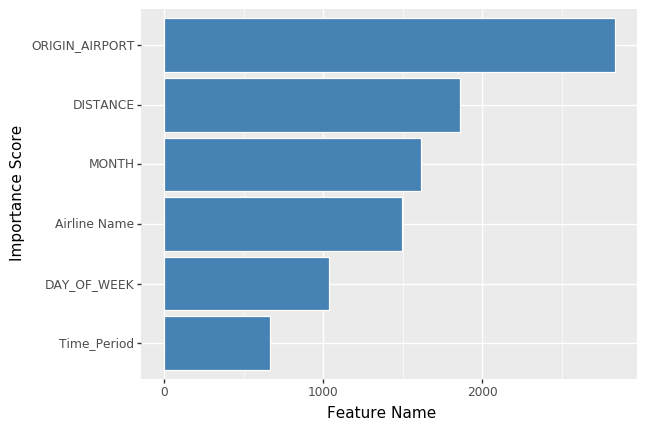

<ggplot: (144043587185)>

In [64]:
ggplot(feat_imp, aes(x='Feature', y='importance')) +\
  geom_bar(stat="identity",position ="identity",fill='steelblue', color='white') +\
  labs(y = "Feature Name", x = 'Importance Score') +\
  scale_x_discrete(limits=feat_list) +\
  coord_flip()

Interestingly, the origin airport appears to have a large impact on the outcome of the flight, while distance also plays a large factor. This information, however, does not tell us how these factors affect the likelihood of delay based on a feature. SHAP values would be more helpful here.

In [35]:
shap_explainer = shap.TreeExplainer(model_final)

shap_values = shap_explainer.shap_values(X_test)

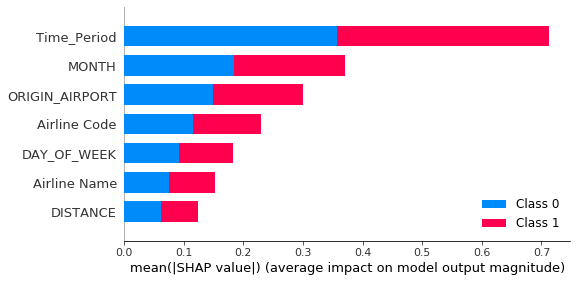

In [37]:
shap.summary_plot(shap_values, X_test)

In [75]:
len(shap_values[1])

1046226

From the chart, we can see that this model does not seem to do a good job on distinguishing between the two classes based on these attributes - there's almost a 50:50 split of them in each classs.


In [84]:
# plot the SHAP values for the first observation
shap.initjs()

shap.force_plot(shap_explainer.expected_value[0], shap_values[0][0], X_test.iloc[0,:])

The plot above helps us see how a single data point comes to be predicted. While this model isn't the best at prediction, SHAP values and studying them do help us see that certain factors (airline = WN and distance in this case) increases the likelihood that a value may be predicted as delay.

In [85]:
# plot the SHAP values for the first observation
shap.initjs()

shap.force_plot(shap_explainer.expected_value[0], shap_values[0][100], X_test.iloc[100,:])

Another example shown above tells us that the morning time period increases the likelihood of a flight being delayed, but in this case distance becomes a feature that drives doen the likelihood. This shows us that many of the independent variables have dependencies with each other.



## VII. Key Takeaways

1. Airline delays are quite common, though long delays (>1h) are rare.

2. Delays seem to be correlated to the time of the day of the flight, in addition to the seaon/month that the flight takes place.

3. Certain airports have higher delay percentages compared to others, though this does not seem to say much about how bad the delay is.

4. Every airline buffers its delay by over-estimating flight time in order to reduce the delay percentage. But this buffer varies between airlines.

5. Using scheduling data alone does not appear to be sufficient in predicting whether a flight would be delayed. Nevertheless, using a tree-based model such as lightGBM allows us to explore the positive and negative assocation of different features to delay

6. Out of all the variables studied in this analysis, the origin airport, the month of travel, and the distance traveled are the most prominent predictors in a flight's delay.